# Analyzing 311 Noise Complaints Data

In [3]:
import urllib2, json, csv
import requests
import itertools
import numpy

from shapely.geometry import shape, Point
from rtree import index
from datetime import datetime, date, timedelta

######################### UTILS #########################
def readJson(url):
    """
    Read a json file.
    :param url: url to be read.
    :return: a json file.
    """
    try:
        response = urllib2.urlopen(url)
        return json.loads(response.read(), strict=False)
    except urllib2.HTTPError as e:
        return None
    
def roundTime(dt=None, roundTo=60):
   """
   Round a datetime object to any time laps in seconds
   :param dt: datetime.datetime object, default now.
   :param roundTo: closest number of seconds to round to, default 1 minute.
   :return: the rounded time.
   """
   if dt == None : dt = datetime.now()
   seconds = (dt - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return dt + timedelta(0, rounding-seconds, -dt.microsecond)

######################### DATA #########################
def getRegions():
    """
    Get the community districts of NY.
    :return: dictionary { region id : coordinates}.
    """
    dict = {}

    url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:22:23.125Z/community-districts-polygon.geojson"
    data = readJson(url)
    for district in data['features']:
        dict[district['id']] = shape(district['geometry'])

    return dict

def get311NoiseComplaints():
    """
    Gets all noise complaints of NY in a date range.
    :return: dictionary {complaint type : total number of complaints of this type} and 
             dictionary {complaint type : (long/lat, hour, complaint type)}.
    """
    query_string = "http://data.cityofnewyork.us/resource/fhrw-4uyv.json"
    query_string += "?"
    query_string += "$where="
    query_string += "(complaint_type like '%Noise%')"
    query_string += " AND "
    query_string += "(created_date>='" + date_ini + "')"
    query_string += " AND "
    query_string += "(created_date<='" + date_end + "')"
    query_string += "&$group=descriptor,latitude,longitude,created_date"
    query_string += "&$select=descriptor,latitude,longitude,created_date"

    result = requests.get(query_string).json()
    
    print query_string

    # Dictionary of complaints
    complaints = {'Air Condition/Ventilation Equipment': 0, 'Alarms': 0,
                  'Banging/Pounding': 0, 'Barking Dog': 0, 'Car/Truck Horn': 0,
                  'Car/Truck Music': 0, 'Construction Equipment': 0,
                  'Construction Before/After Hours': 0, 'Engine Idling': 0,
                  'Ice Cream Truck': 0, 'Jack Hammering': 0, 'Lawn Care Equipment': 0,
                  'Loud Music/Party': 0, 'Loud Talking': 0, 'Loud Television': 0,
                  'Manufacturing Noise': 0, 'Others': 0, 'Private Carting Noise': 0}

    complaints_loc = {}
    for key in complaints:
        complaints_loc[key] = []

    for record in result:
        for key in complaints:
            date = record.get('created_date')
            long = record.get('longitude')
            lat = record.get('latitude')
            if date is not None and long is not None and lat is not None:
                time = roundTime(datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.000'), roundTo=60 * 60)
                if time.weekday():
                    if record.get('descriptor').find(key) > -1:
                        complaints[key] += 1
                        complaints_loc[key].append((float(str(long)), float(str(lat)), time, key))
                        break
                    elif key == "Others":
                        complaints[key] += 1
                        complaints_loc[key].append((float(str(long)), float(str(lat)), time, key))

    return complaints, complaints_loc

######################### FILTER BY REGION #########################
def pointInPolygon(polyDict, points):
    """
    Defines which points are inside which regions.
    :param polyDict: dictionary {region id : polygon}.
    :param points: list of tuples (long, lat).
    :return: dictionaries {region id : number of points} and {region id : points}.
    """
    dict_count = {}
    dict_points = {}

    polygons = []
    # Populate R-tree index with bounds of polygons
    idx = index.Index()
    for pos, poly in enumerate(polyDict):
        dict_count[poly] = 0
        dict_points[poly] = []
        polygon = shape(polyDict[poly])
        polygons.append(polygon)
        idx.insert(pos, polygon.bounds)

    for i, p in enumerate(points):
        point = Point(p[0], p[1])
        # Iterate through spatial index
        for j in idx.intersection(point.coords[0]):
            if point.within(polygons[j]):
                dict_count[j] += 1
                dict_points[j].append(p)

    return dict_count, dict_points

def complaintsPerRegion(regions, complaints):
    """
    Obtain the total number of complaints that falls in a reiong, per hour.
    :param regions: dictionary {region id : polygon}.
    :param complaints: dictionary {complaint type : (long, lat, hour)}.
    return: dictionary {region id : (long/lat, hour, complaint type)}
    """
    values = list(itertools.chain.from_iterable(complaints.values()))
    complaints_per_region, complaints_per_region_points = pointInPolygon(regions, values)

    return complaints_per_region_points

In [4]:
if __name__ == '__main__':
    date_ini = str(date(2015, 01, 01))
    date_end = str(date(2015, 12, 31))
    print "-----> Date Range:", date_ini, date_end

    regions_bbox = getRegions()
    regions_number = len(regions_bbox)
    print "-----> Number of regions:", regions_number

    complaints, complaints_loc = get311NoiseComplaints()
    print "----->", sum([v for v in complaints.values()]), "complaints"
    complaints_region_time = complaintsPerRegion(regions_bbox, complaints_loc)

-----> Date Range: 2015-01-01 2015-12-31
-----> Number of regions: 149
http://data.cityofnewyork.us/resource/fhrw-4uyv.json?$where=(complaint_type like '%Noise%') AND (created_date>='2015-01-01') AND (created_date<='2015-12-31')&$group=descriptor,latitude,longitude,created_date&$select=descriptor,latitude,longitude,created_date
-----> 877 complaints


# 311 Complaints Time Series Visualization

## General Overview 

### 1. Number of Complaints per Category

Air Condition/Ventilation Equipment : 0
Alarms : 15
Banging/Pounding : 31
Barking Dog : 33
Car/Truck Horn : 15
Car/Truck Music : 56
Construction Before/After Hours : 127
Construction Equipment : 38
Engine Idling : 23
Ice Cream Truck : 6
Jack Hammering : 16
Lawn Care Equipment : 0
Loud Music/Party : 353
Loud Talking : 122
Loud Television : 1
Manufacturing Noise : 1
Others : 31
Private Carting Noise : 9


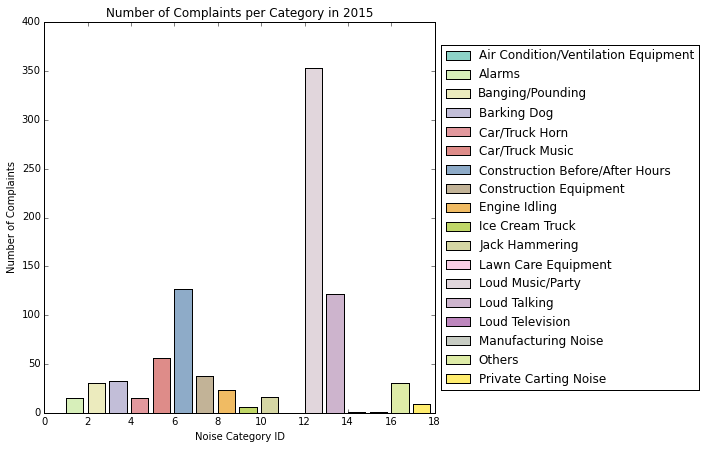

In [5]:
%matplotlib inline

import numpy
import matplotlib
import matplotlib.pyplot as plt

import collections

cmap = plt.get_cmap('Set3')
colors = [cmap(i) for i in numpy.linspace(0, 1, len(complaints))]
complaints = collections.OrderedDict(sorted(complaints.items()))

plt.figure(figsize=(7, 7), dpi=200)
item = 0
for key, value in complaints.iteritems():
    print key, ':', value
    plt.bar(item, value, label=key, color=colors[item])
    item += 1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
plt.xlabel('Noise Category ID')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints per Category in 2015')

### 2. Filtering by Time

In [7]:
complaints_time = {}
for key in complaints:
        complaints_time[key] = []
        
for key, value in complaints_region_time.iteritems():
    for item in value:
        new_key = item[3]
        new_value = item[2]
        complaints_time[new_key].append(new_value)

complaints_hour = numpy.zeros((18, 24))
complaints_day = numpy.zeros((18, 7))
complaints_month = numpy.zeros((18, 12))

complaints_time = collections.OrderedDict(sorted(complaints_time.items()))  # To guarantee keys order
index = 0
for key, value in complaints_time.iteritems():
    for item in value:
        hour = item.hour          # Between 0 and 23
        weekday = item.weekday()  # Starts on Monday
        month = item.month - 1    # Between 1 and 12
        
        complaints_hour[index, hour] += 1
        complaints_day[index, weekday] += 1
        complaints_month[index, month] += 1
    index += 1

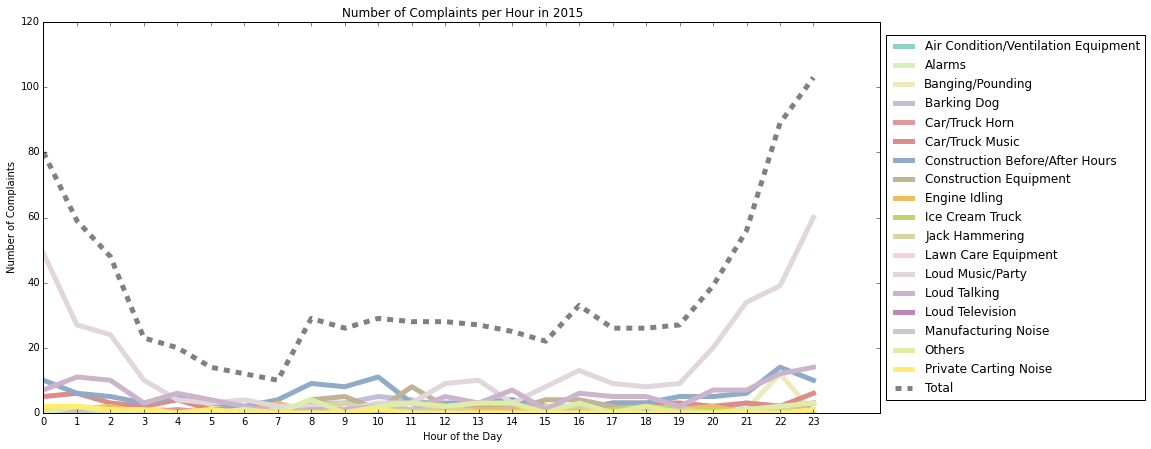

In [8]:
keys = sorted(complaints.keys())
y = range(complaints_hour.shape[1])

plt.figure(figsize=(15, 7), dpi=200)
for i in range(complaints_hour.shape[0]):
    plt.plot(y, complaints_hour[i,:], label=keys[i], color=colors[i], linewidth=5)
plt.plot(y, numpy.sum(complaints_hour, axis=0), label='Total', color='gray', linewidth=5, linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.xticks(numpy.arange(0, 24, 1))
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints per Hour in 2015')

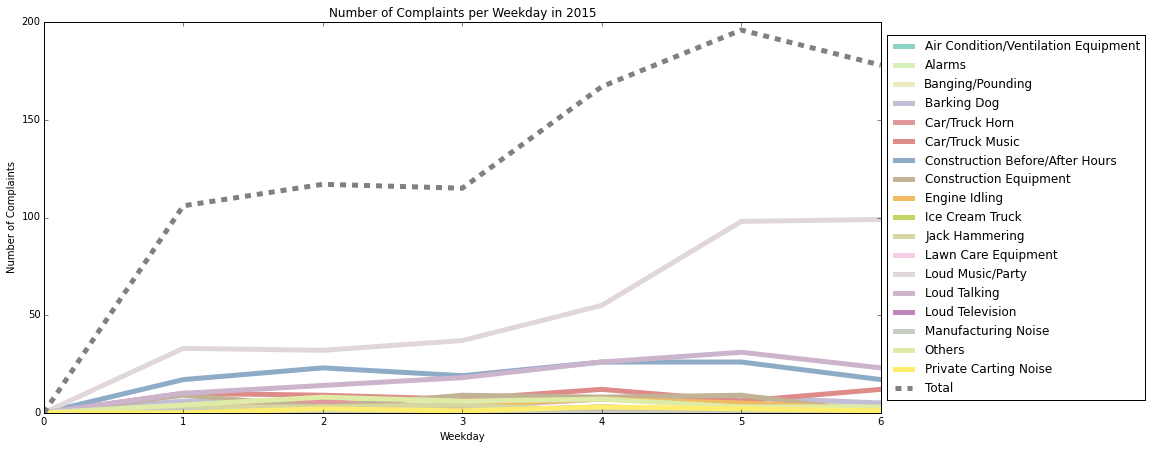

In [9]:
y = range(complaints_day.shape[1])

plt.figure(figsize=(15, 7), dpi=200)
for i in range(complaints_day.shape[0]):
    plt.plot(y, complaints_day[i,:], label=keys[i], color=colors[i], linewidth=5)
plt.plot(y, numpy.sum(complaints_day, axis=0), label='Total', color='gray', linewidth=5, linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.xlabel('Weekday')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints per Weekday in 2015')

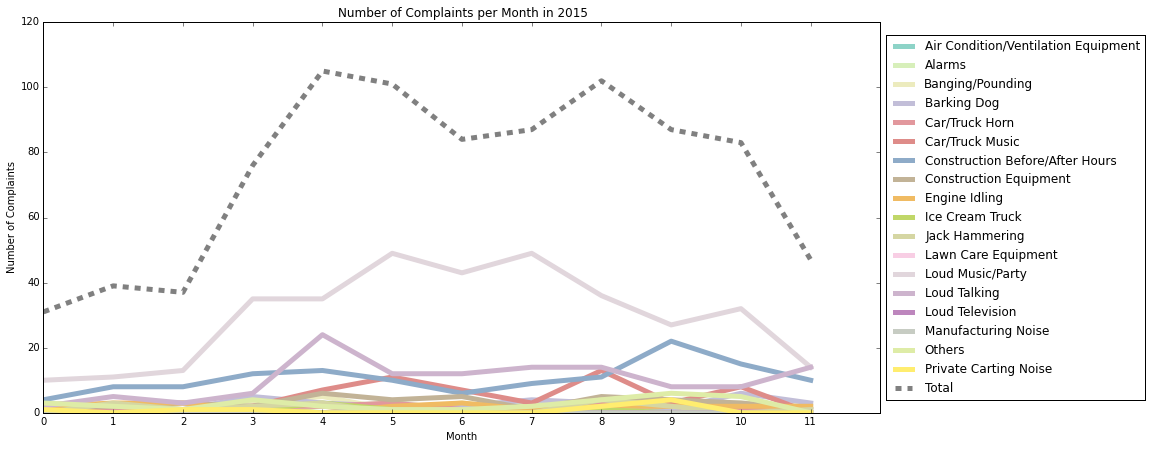

In [10]:
y = range(complaints_month.shape[1])

plt.figure(figsize=(15, 7), dpi=200)
for i in range(complaints_month.shape[0]):
    plt.plot(y, complaints_month[i,:], label=keys[i], color=colors[i], linewidth=5)
plt.plot(y, numpy.sum(complaints_month, axis=0), label='Total', color='gray', linewidth=5, linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.xticks(numpy.arange(0, 12, 1))
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints per Month in 2015')